In [1]:
import pandas as pd
import time
from transformers import AutoTokenizer
from is_turkish import get_is_turkish
from is_pure import get_is_pure

df = pd.read_parquet("hf://datasets/alibayram/yapay_zeka_turkce_mmlu_model_cevaplari/data/train-00000-of-00001.parquet")
df = df[["soru", "secenekler"]]
text = ""
for _, row in df.iterrows():
    text += row["soru"] + "\n"  
    for secenek in row["secenekler"]:
        text += secenek + "\n"

len(text), len(text.split())

/Users/alibayram/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(1605376, 198193)

In [2]:
len(text.split())

198193

In [3]:
def score_tokenizer(text:str, tokenizer_score_map: dict):
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_score_map["tokenizer"])
  tokenizer_score_map["vocab-size"] = len(tokenizer.get_vocab())
  time_start = time.time()

  token_ids = tokenizer.encode(text)
  tokenizer_score_map["tokens-count"] = len(token_ids)

  tokens = []

  for token_id in token_ids:
    try:
      token = tokenizer.decode(token_id)
      tokens.append(token)
    except:
      print("Error: ", token_id)

  time_end = time.time()

  tokenizer_score_map["time"] = round(time_end - time_start, 4)
  
  tokens = set(tokens)
  is_turkish_map = get_is_turkish(tokens)
  tokenizer_score_map["unique-token-count"] = len(is_turkish_map)

  # count of true values in is_turkish_map
  tokenizer_score_map["turkish-token-count"] = sum(is_turkish_map.values())
  tokenizer_score_map["turkish-token-percent"] = round(tokenizer_score_map["turkish-token-count"] / tokenizer_score_map["unique-token-count"], 4)

  is_pure_map = get_is_pure(" ".join(is_turkish_map.keys()))
  # count of true values in is_pure_map
  tokenizer_score_map["pure-token-count"] = sum(is_pure_map.values())
  tokenizer_score_map["pure-token-percent"] = round(tokenizer_score_map["pure-token-count"] / tokenizer_score_map["unique-token-count"], 4)
  

  return tokenizer_score_map

In [4]:
tokenizers = [
  "google/gemma-2-9b",
  "alibayram/tr_tokenizer",
  "AhmetSemih/tr_tokenizer",
  "aliarda/turkish_tokenizer_256k",
  "aliarda/turkish_tokenizer",
  "meta-llama/Llama-3.2-3B",
  "utter-project/EuroLLM-9B-Instruct",
  "Qwen/Qwen2.5-7B-Instruct",
  "CohereForAI/aya-expanse-8b",
  "openai-community/gpt2",
  "mistralai/Mistral-Nemo-Instruct-2407",
  "microsoft/Phi-3.5-mini-instruct",
  "microsoft/phi-4",
  "Trendyol/Trendyol-LLM-8b-chat-v2.0",
  "ytu-ce-cosmos/turkish-gpt2-large-750m-instruct-v0.1"
]

In [ ]:
tokenizer_score_maps = []

for tokenizer in tokenizers:
  tokenizer_score_map = {
    "tokenizer": tokenizer
  }
  tokenizer_score_map = score_tokenizer(text, tokenizer_score_map)
  tokenizer_score_maps.append(tokenizer_score_map)
  print(tokenizer_score_map)

df = pd.DataFrame(tokenizer_score_maps)
df.to_csv("tokenizer_score_maps.csv", index=False)

In [57]:
df

,tokenizer,vocab-size,tokens-count,time,unique-token-count,turkish-token-count,turkish-token-percent,pure-token-count,pure-token-percent
0,google/gemma-2-9b,256000,497015,2.9500,6383,3104,0.4863,2365,0.3705
1,alibayram/tr_tokenizer,30158,476556,2.4231,11531,11342,0.9836,11055,0.9587
2,AhmetSemih/tr_tokenizer,59572,451883,2.4849,13370,13253,0.9912,13357,0.9990
3,aliarda/turkish_tokenizer_256k,256000,488267,2.5124,13631,13351,0.9795,12981,0.9523
4,aliarda/turkish_tokenizer,58526,451936,2.3406,13268,13170,0.9926,13256,0.9991
5,meta-llama/Llama-3.2-3B,128256,488535,3.1249,6823,3125,0.4580,2109,0.3091
6,utter-project/EuroLLM-9B-Instruct,128000,497173,3.2019,5226,2457,0.4701,1838,0.3517
7,Qwen/Qwen2.5-7B-Instruct,151665,561866,3.3150,5752,2320,0.4033,1734,0.3015
8,CohereForAI/aya-expanse-8b,255029,434526,2.7651,8562,4338,0.5067,2822,0.3296
9,openai-community/gpt2,50257,821139,4.3765,3454,1582,0.4580,1119,0.3240


In [1]:
import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")
enc.decode([43519, 95938])

/Users/alibayram/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


' Risk yönet'

In [8]:
# save vocabs to disk
tokens = []
for i in range(0, enc.n_vocab):
  try:
    tokens.append(enc.decode([i]))
  except:
    print("Error: ", i)
tokens

Error:  199998
Error:  200000
Error:  200001
Error:  200002
Error:  200003
Error:  200004
Error:  200005
Error:  200006
Error:  200007
Error:  200008
Error:  200009
Error:  200010
Error:  200011
Error:  200012
Error:  200013
Error:  200014
Error:  200015
Error:  200016
Error:  200017


thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:179:64:
n

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�',
 '�

In [9]:
len(tokens)

200000

In [4]:
def score_openai_tokenizer(text:str, tokenizer_score_map: dict):

  tokenizer_score_map["vocab-size"] = enc.n_vocab
  time_start = time.time()

  token_ids = enc.encode(text)
  tokenizer_score_map["tokens-count"] = len(token_ids)

  tokens = []

  for token_id in token_ids:
    try:
      token = enc.decode([token_id])
      tokens.append(token)
    except:
      print("Error: ", token_id)

  time_end = time.time()

  tokenizer_score_map["time"] = round(time_end - time_start, 4)
  
  tokens = set(tokens)
  is_turkish_map = get_is_turkish(tokens)
  tokenizer_score_map["unique-token-count"] = len(is_turkish_map)

  # count of true values in is_turkish_map
  tokenizer_score_map["turkish-token-count"] = sum(is_turkish_map.values())
  tokenizer_score_map["turkish-token-percent"] = round(tokenizer_score_map["turkish-token-count"] / tokenizer_score_map["unique-token-count"], 4)

  is_pure_map = get_is_pure(" ".join(is_turkish_map.keys()))
  # count of true values in is_pure_map
  tokenizer_score_map["pure-token-count"] = sum(is_pure_map.values())
  tokenizer_score_map["pure-token-percent"] = round(tokenizer_score_map["pure-token-count"] / tokenizer_score_map["unique-token-count"], 4)
  

  return tokenizer_score_map

In [ ]:
openai_tokenizer_score_map = {
  "tokenizer": "openai/o200k_base-gpt-4o"
}

openai_tokenizer_score_map = score_openai_tokenizer(text, openai_tokenizer_score_map)

/Users/alibayram/Library/Python/3.9/lib/python/site-packages/pip_system_certs/wrapt_requests.py:71: UserWarning: Failed to patch SSL settings for unverified requests (unsupported version of urllib3?)
This may lead to errors when urllib3 tries to modify verify_mode.
Please report an issue at https://gitlab.com/alelec/pip-system-certs with your
python version included in the description

  warnings.warn(


In [ ]:
df = pd.read_csv("tokenizer_score_maps.csv")
df = pd.concat([df, pd.DataFrame([openai_tokenizer_score_map])])
df.to_csv("tokenizer_score_maps.csv", index=False)
df

,tokenizer,vocab-size,tokens-count,time,unique-token-count,turkish-token-count,turkish-token-percent,pure-token-count,pure-token-percent
0,google/gemma-2-9b,256000,497015,2.9500,6383,3104,0.4863,2365,0.3705
1,alibayram/tr_tokenizer,30158,476556,2.4231,11531,11342,0.9836,11055,0.9587
2,AhmetSemih/tr_tokenizer,59572,451883,2.4849,13370,13253,0.9912,13357,0.9990
3,aliarda/turkish_tokenizer_256k,256000,488267,2.5124,13631,13351,0.9795,12981,0.9523
4,aliarda/turkish_tokenizer,58526,451936,2.3406,13268,13170,0.9926,13256,0.9991
5,meta-llama/Llama-3.2-3B,128256,488535,3.1249,6823,3125,0.4580,2109,0.3091
6,utter-project/EuroLLM-9B-Instruct,128000,497173,3.2019,5226,2457,0.4701,1838,0.3517
7,Qwen/Qwen2.5-7B-Instruct,151665,561866,3.3150,5752,2320,0.4033,1734,0.3015
8,CohereForAI/aya-expanse-8b,255029,434526,2.7651,8562,4338,0.5067,2822,0.3296
9,openai-community/gpt2,50257,821139,4.3765,3454,1582,0.4580,1119,0.3240


In [24]:
import pandas as pd

df = pd.read_csv("yapay_zeka_turkce_mmlu_liderlik_tablosu.csv")
# remove format, quantization_level, dogru_cevap_sayisi, toplam_sure columns
# df = df.drop(columns=["format", "quantization_level", "dogru_cevap_sayisi", "toplam_sure"])
df

,model,family,parameter_size,basari
0,gpt-4o,GPT,Unknown,84.84
1,gemma2:27b,gemma2,27.2B,72.10
2,aya-expanse:32b,command-r,32.3B,70.66
3,llama3.1:70b,llama,70.6B,70.42
4,qwen2.5:latest,qwen2,7.6B,61.68
5,alibayram/erurollm-9b-instruct:latest,llama,9.2B,51.29
6,mistral-nemo:latest,llama,12.2B,46.89
7,phi3.5:latest,phi3,3.8B,29.37


In [23]:
df.to_csv("yapay_zeka_turkce_mmlu_liderlik_tablosu.csv", index=False)

In [26]:
df_tokenizer_score_maps = pd.read_csv("tokenizer_score_maps_copy.csv")
# df = df.drop(columns=["format", "quantization_level", "dogru_cevap_sayisi", "toplam_sure"])
df_tokenizer_score_maps.drop(columns=["turkish-token-count", "pure-token-count"], inplace=True)
df_tokenizer_score_maps

,tokenizer,mmlu_model_parameter_size,mmlu_score,vocab-size,tokens-count,time,unique-token-count,turkish-token-percent,pure-token-percent
0,google/gemma-2,27.2,72.10,256000,497015,2.9500,6383,0.4863,0.3705
1,meta-llama/Llama-3.1,70.6,70.42,128256,488535,3.1249,6823,0.4580,0.3091
2,utter-project/EuroLLM,9.2,51.29,128000,497173,3.2019,5226,0.4701,0.3517
3,Qwen/Qwen2.5,7.6,61.68,151665,561866,3.3150,5752,0.4033,0.3015
4,CohereForAI/aya-expanse,32.3,70.66,255029,434526,2.7651,8562,0.5067,0.3296
5,mistralai/Mistral-Nemo,12.2,46.89,131072,534930,3.1405,4354,0.4527,0.3608
6,microsoft/Phi-3.5,3.8,29.37,32011,803971,4.5526,3640,0.4393,0.3442
7,openai/o200k_base-gpt-4o,Unknown,84.84,200019,491137,0.5147,7615,0.4214,0.2868


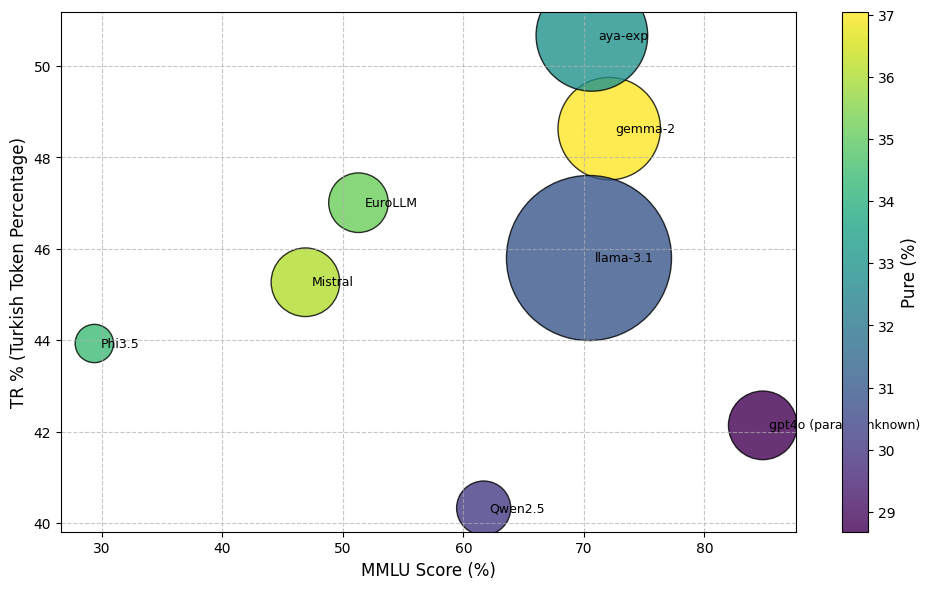

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the analysis
tokenizers = ['gemma-2', 'llama-3.1', 'EuroLLM', 'Qwen2.5', 'aya-exp', 'Mistral', 'Phi3.5', 'gpt4o']
mmlu_scores = [72.10, 70.42, 51.29, 61.68, 70.66, 46.89, 29.37, 84.84]
tr_percent = [48.63, 45.80, 47.01, 40.33, 50.67, 45.27, 43.93, 42.14]
pure_percent = [37.05, 30.91, 35.17, 30.15, 32.96, 36.08, 34.42, 28.68]

# Parameter sizes (in billions), with None for unknown
parameter_sizes = [27.2, 70.6, 9.2, 7.6, 32.3, 12.2, 3.8, None]  # gpt4o unknown

# Determine a default size for the unknown parameter
# For example, use the median of known sizes
known_sizes = [p for p in parameter_sizes if p is not None]
default_size = np.median(known_sizes)

# Replace None with default size
parameter_sizes = [default_size if p is None else p for p in parameter_sizes]

# Normalize sizes for plotting
size_scale = 200
marker_sizes = [p * size_scale for p in parameter_sizes]

fig, ax = plt.subplots(figsize=(10, 6))

# Create a scatter plot with color mapped to Pure%
sc = ax.scatter(mmlu_scores, tr_percent, c=pure_percent, s=marker_sizes, 
                cmap='viridis', alpha=0.8, edgecolor='black')

# Add text labels for each point
for i, tok in enumerate(tokenizers):
    label_text = tok
    # Indicate if parameter size was unknown
    if tok == 'gpt4o':
        label_text += " (param unknown)"
    ax.text(mmlu_scores[i] + 0.5, tr_percent[i], label_text, fontsize=9, va='center')

# Colorbar for Pure%
cbar = plt.colorbar(sc)
cbar.set_label('Pure (%)', fontsize=12)

# Set axes labels and title
ax.set_xlabel('MMLU Score (%)', fontsize=12)
ax.set_ylabel('TR % (Turkish Token Percentage)', fontsize=12)
# ax.set_title('Model Comparison: MMLU vs TR%, Parameter Size (Unknown for gpt4o), and Pure%', fontsize=14)

# Optional grid
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()
